In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
models=['graphcast_','graphcast-oper','pangu_','pangu-oper','fcnv2_dawn','ifs']
references=['era','ifs_init']
figpath='/users/mfeldman/figs/scores/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black



graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs


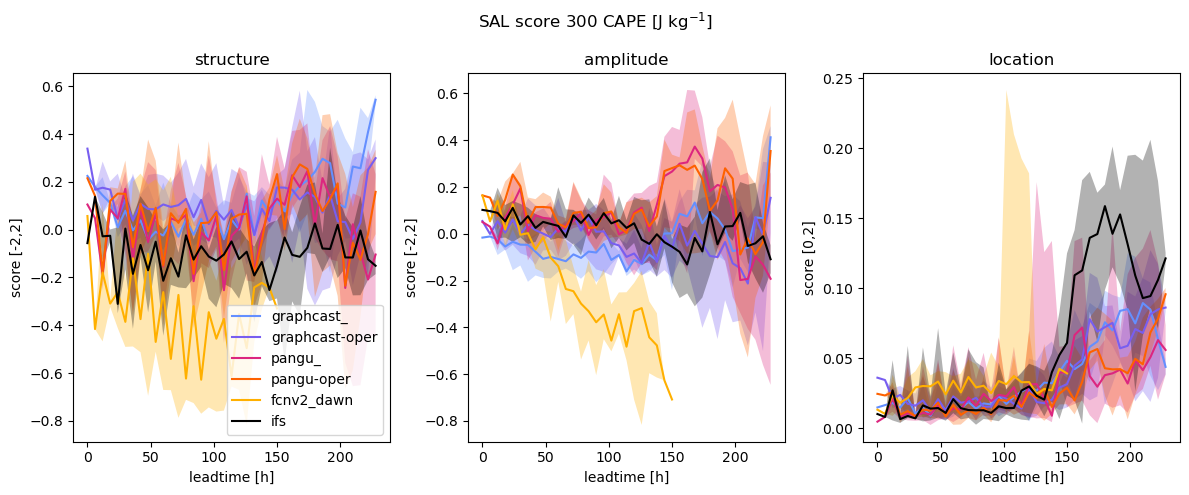

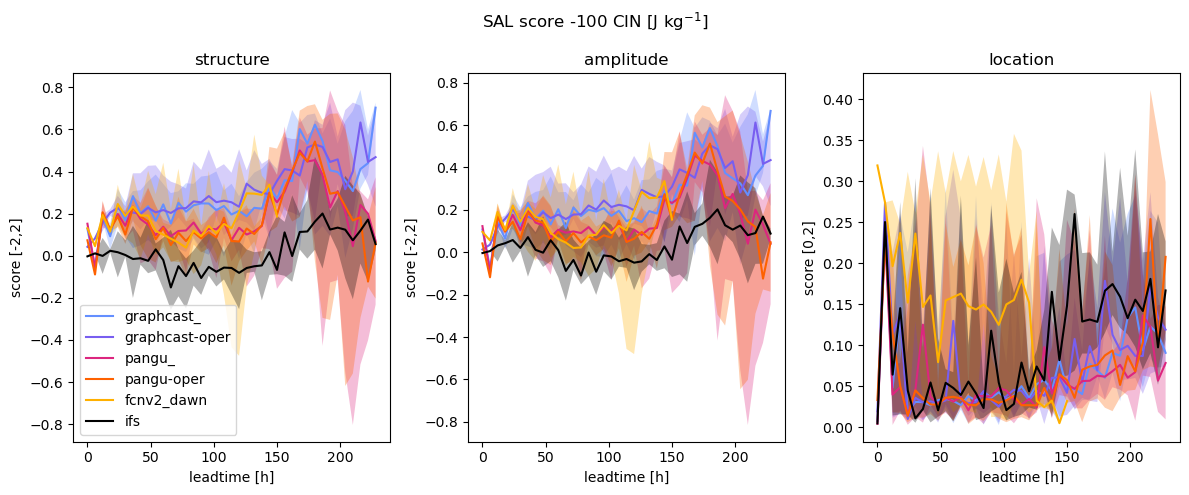

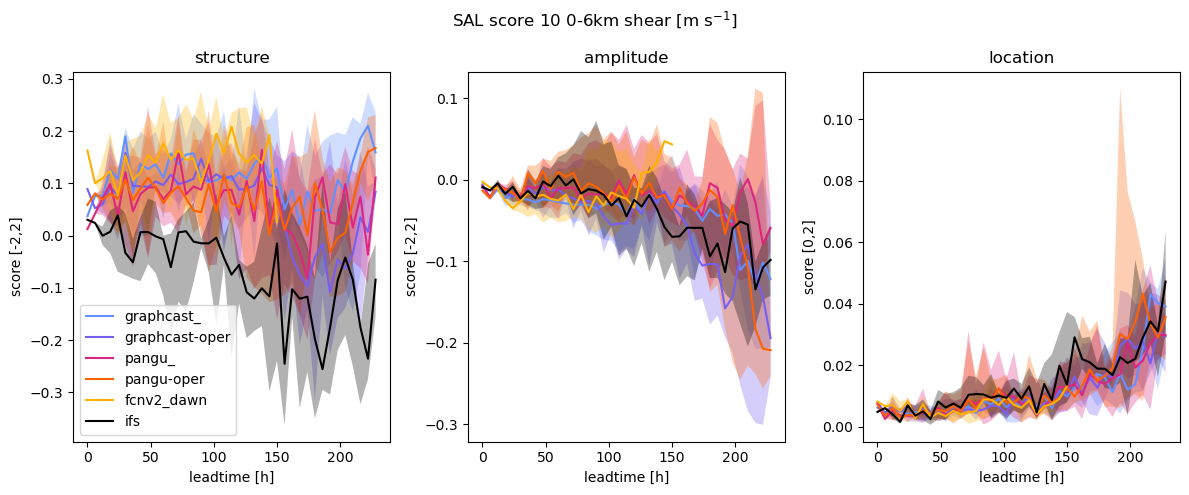

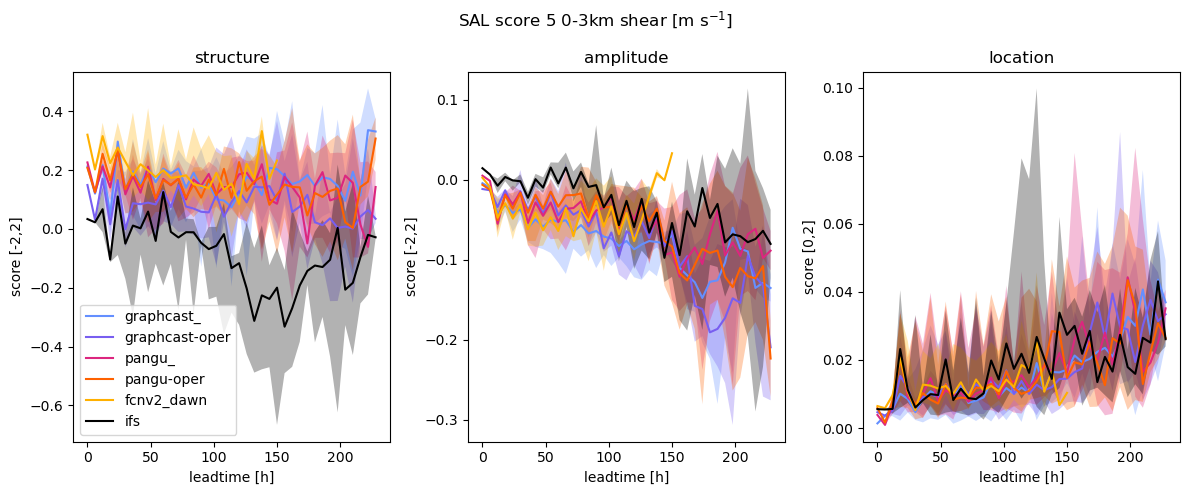

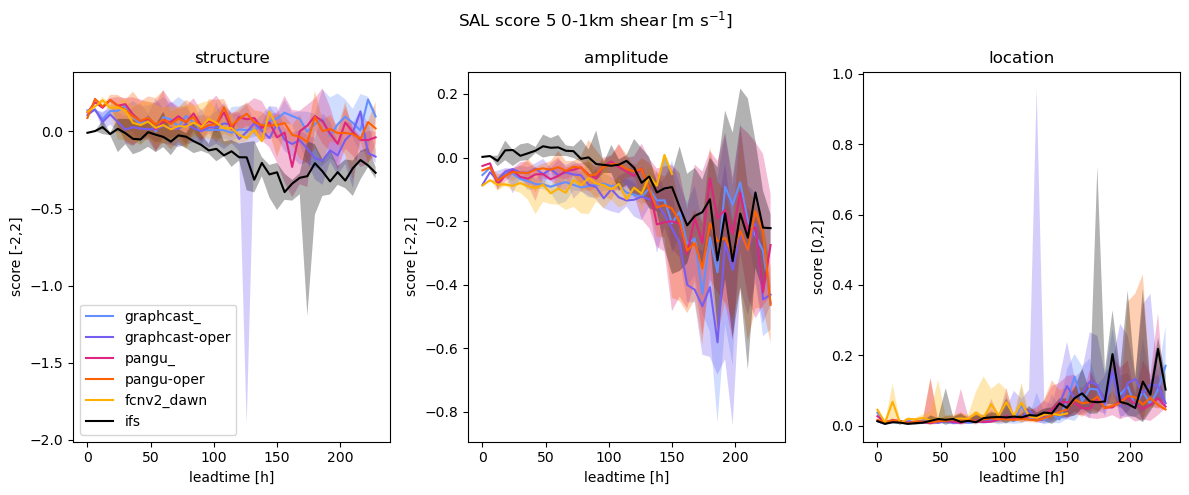

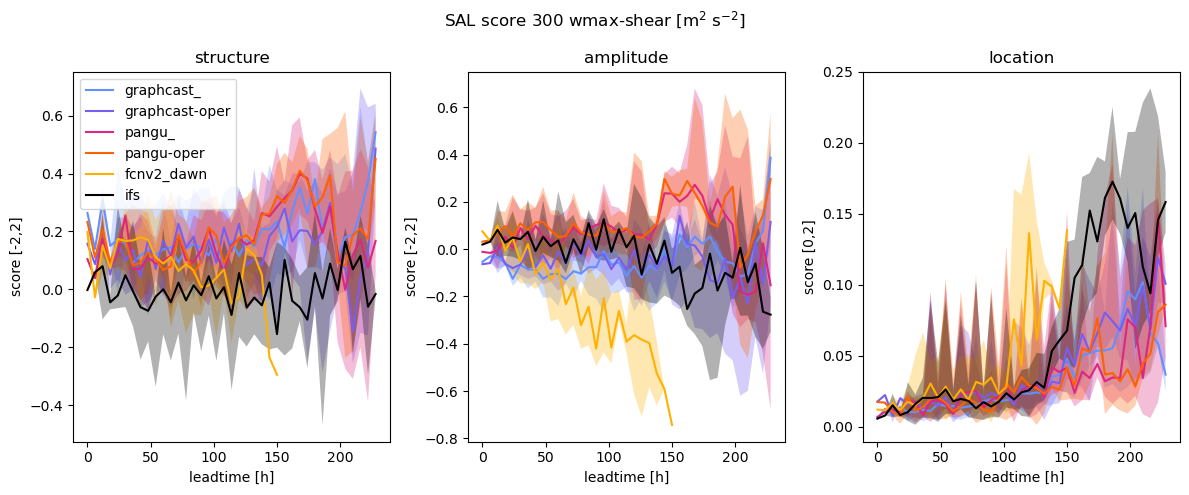

In [12]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(6):
    var=['cape','cin','bs_06','bs_03','bs_01','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,20,10,10,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models)):
        kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        color=[c1,c2,c3,c4,c5,c6][nn]
        print(model)
        i=8
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'),reverse=True)
        sal_s=np.zeros([2*len(files)+i,len(files)]); sal_s[:]=np.nan
        sal_a=np.zeros([2*len(files)+i,len(files)]); sal_a[:]=np.nan
        sal_l=np.zeros([2*len(files)+i,len(files)]); sal_l[:]=np.nan

        

        for file in range(len(files)):
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            if var=='wms':
                capem=model_set.cape.squeeze().values
                wmsm=(capem * 2)**0.5 * model_set.bs_06
                model_set=model_set.assign(wms=lambda model_set: wmsm )
            for tstep in range(len(model_set[kw2])):
                ref=era_ref[var].values[tstep,:,:]
                ref[f1*ref<l1]=0
                mod=model_set[var].values[tstep,:,:]
                mod[f1*mod<l1]=0

                (sal_s[tstep+2*file,file],sal_a[tstep+2*file,file],sal_l[tstep+2*file,file]) = sal(mod, 
                                                                                                   ref)

        axes2[0].plot(np.arange(i+2*len(files))*6,np.nanmedian(sal_s,axis=1),c=color,label=model)
        axes2[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_s,axis=1),np.nanmin(sal_s,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('structure')
        axes2[0].set_xlabel('leadtime [h]')
        axes2[0].set_ylabel('score [-2,2]')
        axes2[0].legend()
        axes2[1].plot(np.arange(i+2*len(files))*6,np.nanmedian(sal_a,axis=1),c=color,label=model)
        axes2[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_a,axis=1),np.nanmin(sal_a,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('amplitude')
        axes2[1].set_xlabel('leadtime [h]')
        axes2[1].set_ylabel('score [-2,2]')
        axes2[2].plot(np.arange(i+2*len(files))*6,np.nanmedian(sal_l,axis=1),c=color)
        axes2[2].fill_between(np.arange(i+2*len(files))*6,np.nanmax(sal_l,axis=1),np.nanmin(sal_l,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('location')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('score [0,2]')
        fig2.suptitle('SAL score '+str(l1)+' '+tit)


    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_sal_scores.png')


graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs


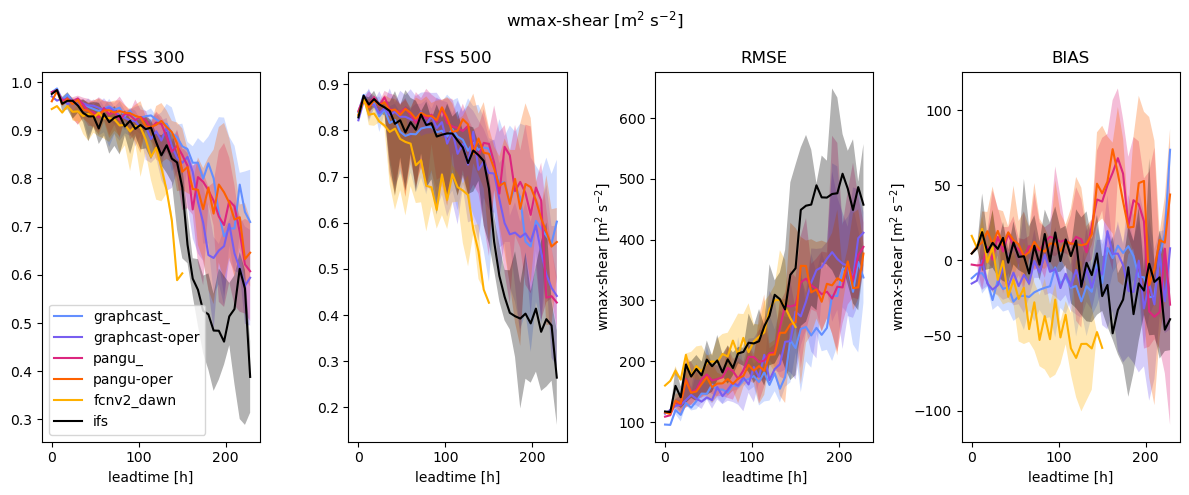

In [12]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(6):
    var=['cape','cin','bs_06','bs_03','bs_01','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,20,10,10,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,4,figsize=(12, 5))
    for nn in range(len(models)):
        kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        print(model)
        i=8
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'),reverse=True)
        fss_eval_300=np.zeros([2*len(files)+i,len(files)]); fss_eval_300[:]=np.nan
        fss_eval_1000=np.zeros([2*len(files)+i,len(files)]); fss_eval_1000[:]=np.nan
        rmse=np.zeros([2*len(files)+i,len(files)]); rmse[:]=np.nan
        bias=np.zeros([2*len(files)+i,len(files)]); bias[:]=np.nan
        for file in range(len(files)):
            #print(files[file])
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            if var=='wms':
                capem=model_set.cape.squeeze().values
                wmsm=(capem * 2)**0.5 * model_set.bs_06
                model_set=model_set.assign(wms=lambda model_set: wmsm )
            for tstep in range(len(model_set[kw2])):
                
                fss_eval_300[tstep+2*file,file] = fss(f1*model_set[var].values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l1, scale=4)
                fss_eval_1000[tstep+2*file,file] = fss(f1*model_set.cape.values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l2, scale=4)
                
                rmse[tstep+2*file,file] = np.nanmean((model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])**2)**0.5
                
                bias[tstep+2*file,file] = np.nanmean(model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])
                
        color=[c1,c2,c3,c4,c5,c6][nn]

        
        
        # axes[0].plot(range(8+len(files)),fss_eval,c=color)
        # axes[1].plot(range(8+len(files)),rmse,c=color)
        # axes[2].plot(range(8+len(files)),bias,c=color)
    
        axes2[0].plot(np.arange(i+2*len(files))*6,np.nanmedian(fss_eval_300,axis=1),c=color,label=model)
        axes2[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(fss_eval_300,axis=1),np.nanmin(fss_eval_300,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('FSS '+str(l1))
        axes2[0].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[0].legend()
        axes2[1].plot(np.arange(i+2*len(files))*6,np.nanmedian(fss_eval_1000,axis=1),c=color,label=model)
        axes2[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(fss_eval_1000,axis=1),np.nanmin(fss_eval_1000,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('FSS '+str(l2))
        axes2[1].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[2].plot(np.arange(i+2*len(files))*6,np.nanmedian(rmse,axis=1),c=color)
        axes2[2].fill_between(np.arange(i+2*len(files))*6,np.nanmax(rmse,axis=1),np.nanmin(rmse,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('RMSE')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel(tit)
        axes2[3].plot(np.arange(i+2*len(files))*6,np.nanmedian(bias,axis=1),c=color)
        axes2[3].fill_between(np.arange(i+2*len(files))*6,np.nanmax(bias,axis=1),np.nanmin(bias,axis=1),facecolor=color,alpha=0.3)
        axes2[3].set_title('BIAS')
        axes2[3].set_xlabel('leadtime [h]')
        axes2[3].set_ylabel(tit)
        fig2.suptitle(tit)
    
        # axes2[0].boxplot(np.transpose(fss_eval),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[1].boxplot(np.transpose(rmse),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[2].boxplot(np.transpose(bias),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
    # fig.show()
    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_scores.png')
            
    # print(fss_eval)
    # print(rmse)
    # print(bias)

graphcast_
making kdeplot
formatting kdeplot
graphcast-oper
making kdeplot
formatting kdeplot
pangu_
making kdeplot
formatting kdeplot
pangu-oper
making kdeplot
formatting kdeplot
fcnv2_dawn
making kdeplot
formatting kdeplot
ifs
making kdeplot
formatting kdeplot


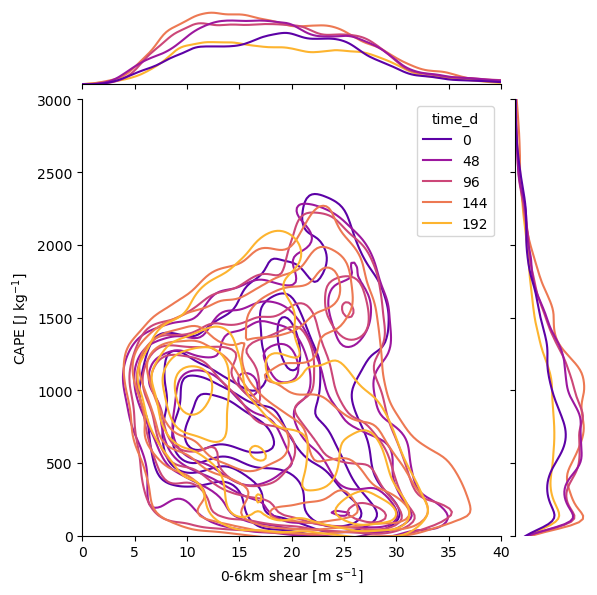

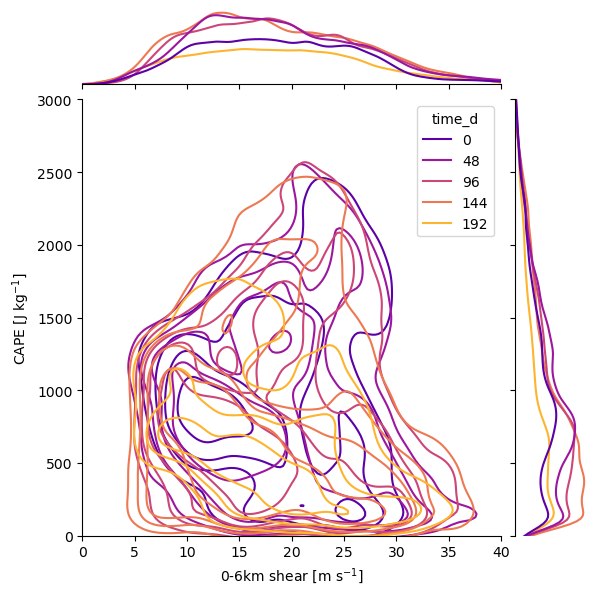

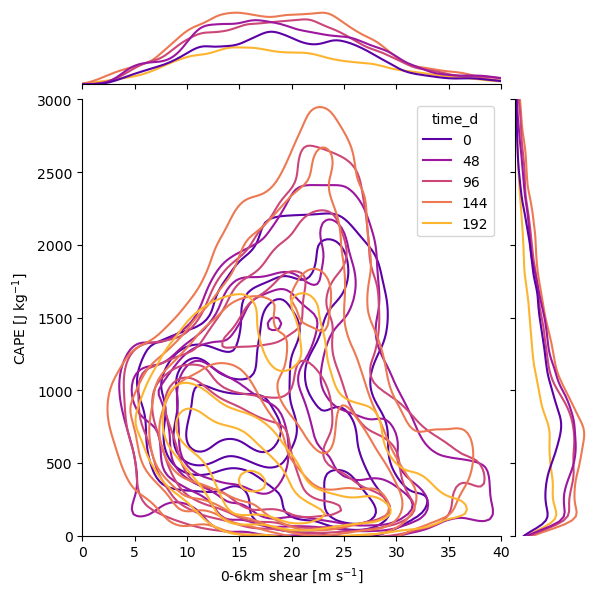

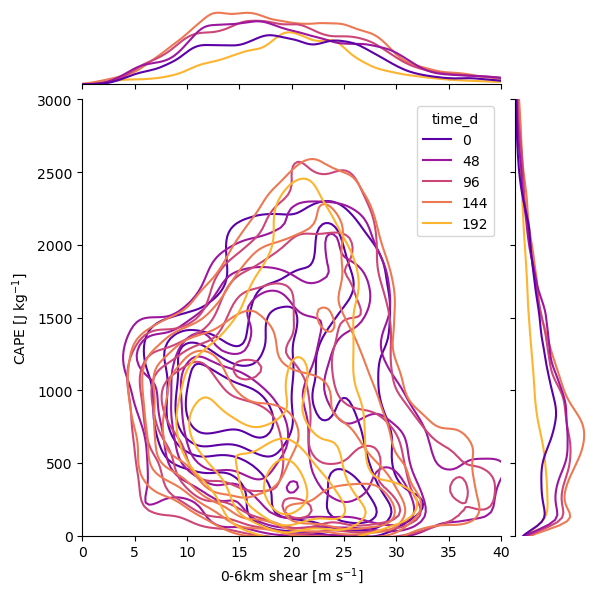

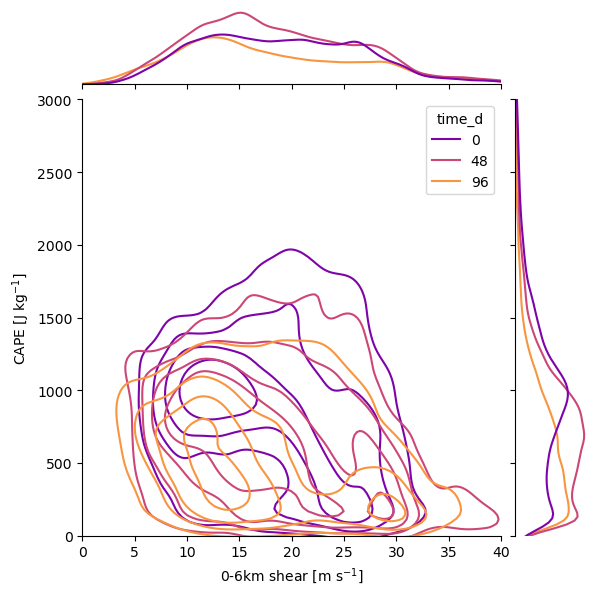

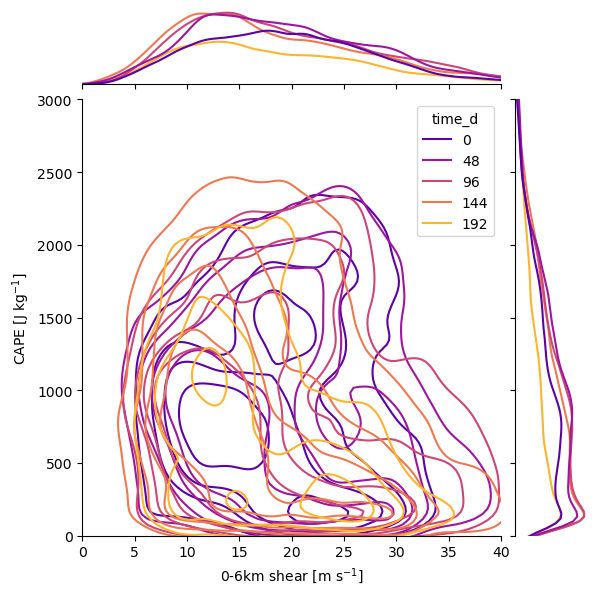

In [26]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
#era_ref=era_ref.assign(wms=lambda era_ref: (era_ref.cape*2)**0.5 * era_ref.bs_06 )
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
cmap = mpl.colormaps['plasma']
i=8
era_covar=np.zeros(i); era_covar[:]=np.nan
era_corr=np.zeros(i); era_corr[:]=np.nan
# for t in range(len(era_covar)):
#     x = era_ref.bs_06.values[t,:,:].flatten()
#     y = era_ref.cape.values[t,:,:].flatten()
#     era_covar[t]=np.cov([x,y])[0,1]
#     era_corr[t]=np.corrcoef([x,y])[0,1]
# fig3,axes3 = plt.subplots(1,2,figsize=(8, 5))
# axes3[0].plot(np.arange(0,240,6),np.nanmedian(era_covar)*np.ones(np.arange(0,240,6).shape),c='grey',label='era5')
# axes3[0].plot(np.arange(0,240,6),np.nanmin(era_covar)*np.ones(np.arange(0,240,6).shape),c='grey',linestyle='--')
# axes3[0].plot(np.arange(0,240,6),np.nanmax(era_covar)*np.ones(np.arange(0,240,6).shape),c='grey',linestyle='--')
# axes3[1].plot(np.arange(0,240,6),np.nanmedian(era_corr)*np.ones(np.arange(0,240,6).shape),c='grey',label='era5')
# axes3[1].plot(np.arange(0,240,6),np.nanmin(era_corr)*np.ones(np.arange(0,240,6).shape),c='grey',linestyle='--')
# axes3[1].plot(np.arange(0,240,6),np.nanmax(era_corr)*np.ones(np.arange(0,240,6).shape),c='grey',linestyle='--')

for nn in range(len(models)):
    kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
    kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
    model=models[nn]
    print(model)
    i=8
    if model=='fcnv2_dawn': i=8
    files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'),reverse=True)
    dset=pd.DataFrame()
    covar=np.zeros([2*len(files)+i,len(files)]); covar[:]=np.nan
    corr=np.zeros([2*len(files)+i,len(files)]); corr[:]=np.nan
    for file in range(len(files)):
        #print(files[file])
        model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
        cape=model_set.cape.squeeze().values
        wms=(cape * 2)**0.5 * model_set.bs_06
        model_set=model_set.assign(wms=lambda model_set: wms )
        
        for tstep in range(len(model_set[kw2])):
            #print(tstep, 2*file + tstep)
            x = model_set.bs_06.values[tstep,:,:].flatten()
            y = model_set.cape.values[tstep,:,:].flatten()
            ind=np.where(y<50)
            x = np.delete(x,ind); y = np.delete(y,ind)
            ts=6*(2*file+tstep)*np.ones(x.shape)
            data = {'cape': y,
                    'shear': x,
                    'time': ts}
            # axes3[nn].scatter(x,y,c=ts,cmap='plasma',alpha=0.01,vmin=0,vmax=20)

            hue = cmap( (2*file + tstep) / (2*len(files) + tstep) )
            dset=pd.concat([dset,pd.DataFrame(data)],axis=0)

            # covar[tstep+2*file,file] = np.cov([x,y])[0,1]
            # corr[tstep+2*file,file] = np.corrcoef([x,y])[0,1]
    hue_order=np.arange(0,6*(2*len(files)+i),6)
    color=[c1,c2,c3,c4,c5,c6][nn]
    
    # axes3[0].plot(np.arange(i+2*len(files))*6,np.nanmedian(covar,axis=1),c=color,label=model)
    # axes3[0].fill_between(np.arange(i+2*len(files))*6,np.nanmax(covar,axis=1),np.nanmin(covar,axis=1),facecolor=color,alpha=0.3)
    # axes3[0].set_title('Covariance CAPE-shear')
    # axes3[0].set_xlabel('leadtime [h]')
    # axes3[0].set_ylabel('cov coeff')
    # axes3[0].legend()
    # axes3[1].plot(np.arange(i+2*len(files))*6,np.nanmedian(corr,axis=1),c=color,label=model)
    # axes3[1].fill_between(np.arange(i+2*len(files))*6,np.nanmax(corr,axis=1),np.nanmin(corr,axis=1),facecolor=color,alpha=0.3)
    # axes3[1].set_title('Correlation CAPE-shear')
    # axes3[1].set_xlabel('leadtime [h]')
    # axes3[1].set_ylabel('corr coeff')


    # axes3.set_xlim([0,50])
    # axes3.set_ylim([0,5000])
    
    dset['time_d'] = pd.cut(dset["time"], np.arange(0,6*(2*len(files)+i)+1,48), labels=np.arange(0,6*(2*len(files)+i-6),48))
    print('making kdeplot')
    # sns.kdeplot(data=dset, x="shear", y="cape", hue="time_d", ax=axes3[nn], hue_order=hue_order[::4], 
    #                     palette="plasma",levels=np.arange(0,1.1,0.2) )
    g=sns.jointplot(data=dset, x="shear", y="cape", hue="time_d", kind='kde', hue_order=hue_order[:-8:8], 
                        palette="plasma",levels=np.arange(0,1.1,0.2), xlim=(0,40), ylim=(0,3000) )
    print('formatting kdeplot')

    g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
    g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
    g.savefig(figpath+model+'_kde.png')

    # axes3[nn].set_title(model)
    # axes3[nn].set_xlabel('0-6km shear [m s$^{-1}$]')
    # axes3[nn].set_ylabel('CAPE [J kg$^{-1}$]')
    # axes3[nn].set_xlim([0,40])
    # axes3[nn].set_ylim([0,3000])
            
    # color=[c1,c2,c3,c4,c5,c6][nn]


# fig3.tight_layout()
# fig3.show()
# fig3.savefig(figpath+'capeshear_covar.png')


In [6]:
var='capeshear'
fig3.savefig(figpath+var+'_scatter.png')

In [25]:
np.arange(0,6*(2*len(files)+i)+1,48)
hue_order[:-8:8]

array([  0,  48,  96, 144, 192])

making kde-plot
formatting kdeplot


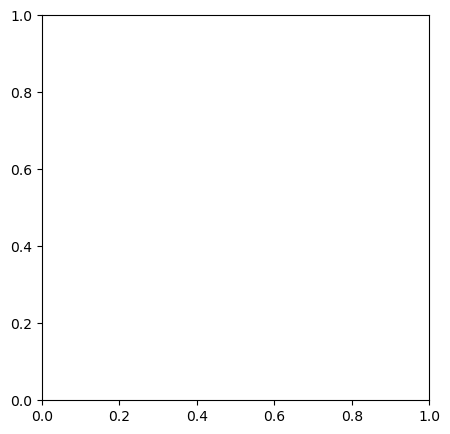

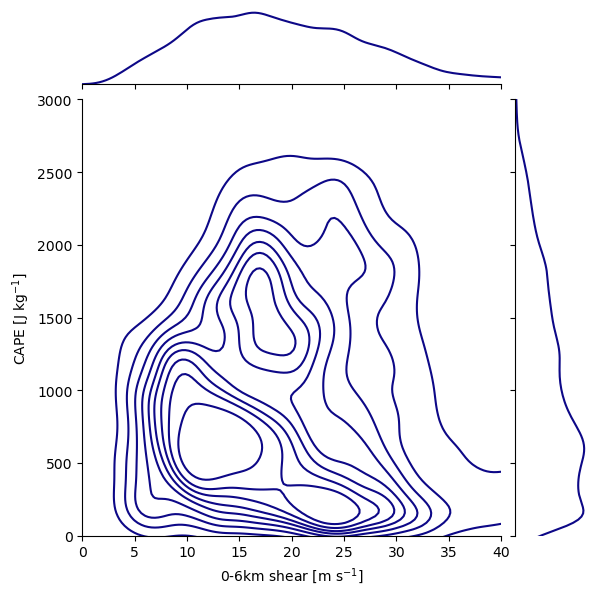

In [14]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
cmap = mpl.colormaps['plasma']
dset=pd.DataFrame()
var='wms'
for tstep in range(len(era_ref['time'])):
    #print(tstep, 2*file + tstep)

    x = era_ref.bs_06.values[tstep,:,:].flatten()
    y = era_ref.cape.values[tstep,:,:].flatten()
    ind=np.where(y<50)
    x = np.delete(x,ind); y = np.delete(y,ind)
    ts=(6*tstep)*np.ones(x.shape)
    data = {'cape': y,
            'shear': x,
            'time': ts}
    # axes3[nn].scatter(x,y,c=ts,cmap='plasma',alpha=0.01,vmin=0,vmax=20)


    dset=pd.concat([dset,pd.DataFrame(data)],axis=0)

print('making kde-plot')
# sns.kdeplot(data=dset, x="shear", y="cape", ax=axes3, color=cmap(0),levels=np.arange(0,1.1,0.1) )
# print('formatting kde-plot')
g=sns.jointplot(data=dset, x="shear", y="cape", kind='kde', color=cmap(0), 
                        levels=np.arange(0,1.1,0.1), xlim=(0,40), ylim=(0,3000) )
print('formatting kdeplot')

g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
g.savefig(figpath+'era5_kde.png')

In [15]:
g.savefig(figpath+'era5_kde.png')

![alt text](attachment:/users/mfeldman/figs/cape_scores.png "CAPE scores")


<img src="/users/mfeldman/figs/CAPE_scores.png" alt="CAPE scores" height="100"> 


<img src="/users/mfeldman/figs/cape_scores.png"> 

In [5]:
## https://gist.github.com/larsmans/3116927
_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64


def hellinger1(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2


def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2


def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

lat, lon =np.meshgrid(era_ref.latitude,era_ref.longitude)

lat=lat.flatten(); lon=lon.flatten(); cape=era_ref.cape.fillna(0).values[0,:,:].flatten()
print(lat.shape)
print(cape.shape)
coords=np.zeros([len(lat),2])
coords[:,0]=lon; coords[:,1]=lat
print(coords.shape)
V = skg.Variogram(coords, cape)
# #determine variogram range to obtain distance, where data is uncorrelated
[range, sill, nugget] = V.parameters


ecdf(sample)

pdf = derivative(ecdf)

jensenshannon(p, q, base=None, *, axis=0, keepdims=False)
# probability distribution -> requires ecdf and pdf

wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)
# probability distribution -> requires ecdf and pdf

correlation(u, v, w=None, centered=True)
#correlation distance

V = skg.Variogram(coords, values)
#determine variogram range to obtain distance, where data is uncorrelated
[range, sill, nugget] = V.parameters


fss(X_f, X_o, thr, scale=range)